<h1>Veggie Tales!</h1>

Group members:
- Palaksh V Rungta
- Madison Hambly
- Felipe Lorenzi
- Jacob Schenberg

Dataset: https://www.kaggle.com/kritikseth/fruit-and-vegetable-image-recognition

Websites Cited/Referred To:

* https://gist.github.com/zed/4221180
* https://docs.python.org/3/library/os.html
* https://stackoverflow.com/questions/902761/saving-a-numpy-array-as-an-image
* https://stackoverflow.com/questions/48248405/cannot-write-mode-rgba-as-jpeg/48248432
* https://towardsdatascience.com/dimensionality-reduction-of-a-color-photo-splitting-into-rgb-channels-using-pca-algorithm-in-python-ba01580a1118

---

# Setup

In [1]:
# importing the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import seaborn as sns
from math import gcd
from PIL import Image
import cv2
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA

In [2]:
#improve plotting resolution
%config InlineBackend.figure_format ='retina'

---

# Exploration

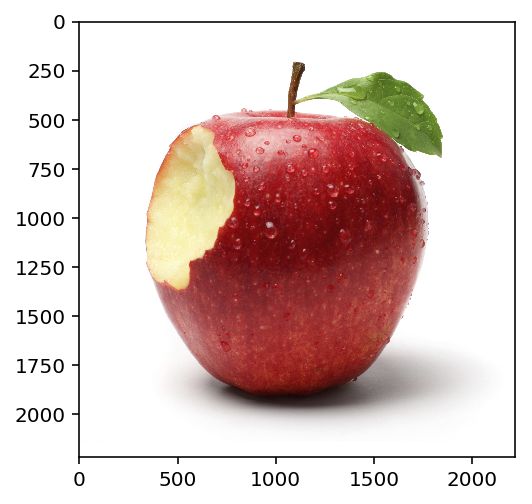

In [3]:
apple_1_fp = './train/apple/Image_1.jpg'
apple_1 = mpimg.imread(apple_1_fp)

plt.imshow(apple_1)

In [4]:
#Dimension of image are 2216 X 2218 with 3 color channels
apple_1.shape

(2216, 2218, 3)

Are the dimensions of every image the same?

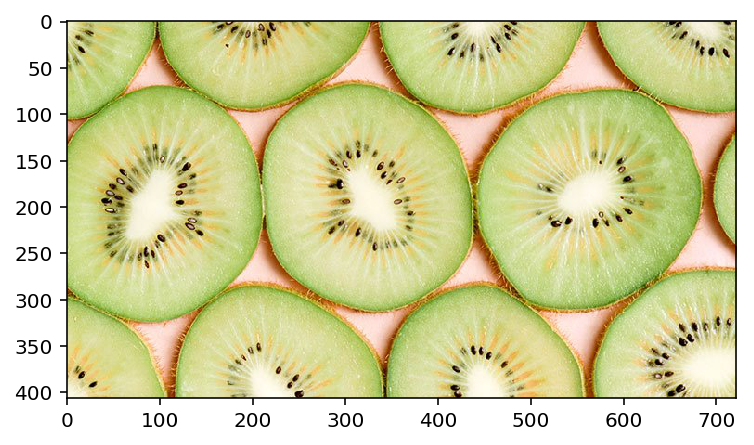

In [5]:
kiwi_fp = './train/kiwi/Image_18.jpg'
kiwi = mpimg.imread(kiwi_fp)

plt.imshow(kiwi)

In [6]:
kiwi.shape

(406, 722, 3)

Doesn't look like it. We will have to crop/resize images

# Cropping and Resizing Images

As we want to perform PCA on our images dataset to reduce the dimensionality of the data, we must get all images to be the exact same size for our PCA algorithm.

To do this, we can crop images to be some aspect ratio, then resize them if needed. However, we have to pick which aspect ratio and size we want all of the images to be.

To find these values, we first look at the sizes of all the images in our dataset to see which aspect ratio and size would be most convenient:

In [7]:
def get_size_aspect_ratio(img):
    
    height, width = img.shape[0], img.shape[1]
    
    #GCD means greatest common divisor
    
    gcd_img = gcd(width, height) # using the math library
    aspect_ratio = (width/gcd_img, height/gcd_img) #ie. aspect ratio of width/gcd : height/gcd
    width_height_ratio = width/height
    
    return [width, height, aspect_ratio, width_height_ratio]

In [8]:
aspect_ratios = pd.DataFrame(columns = ['img_fp', 'width', 'height', 'aspect_ratio', 'width_height_ratio'])

train_dir = './train'
i = 0
for folder in os.listdir(train_dir):
    #Get folder filepath
    folder_dir = os.path.join(train_dir, folder)
    for img_file in os.listdir(folder_dir):
        #Get image filepath
        img_fp = os.path.join(folder_dir, img_file)
        #Read image to array
        try:
            img = mpimg.imread(img_fp)
        except:
            print('ERROR: ' + img_fp)
        #Add data to dataframe
        aspect_ratios.loc[i] = [img_fp] + get_size_aspect_ratio(img)
        i += 1

ERROR: ./train/turnip/Image_22.png


/usr/local/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


ERROR: ./train/lemon/Image_73.png


In [9]:
aspect_ratios

,img_fp,width,height,aspect_ratio,width_height_ratio
0,./train/apple/Image_15.jpg,1067,1600,"(1067.0, 1600.0)",0.666875
1,./train/apple/Image_29.jpg,770,433,"(770.0, 433.0)",1.778291
2,./train/apple/Image_28.jpg,283,424,"(283.0, 424.0)",0.667453
3,./train/apple/Image_14.jpg,1280,720,"(16.0, 9.0)",1.777778
4,./train/apple/Image_16.jpg,250,249,"(250.0, 249.0)",1.004016
...,...,...,...,...,...
3576,./train/carrot/Image_27.jpg,1600,977,"(1600.0, 977.0)",1.637666
3577,./train/carrot/Image_19.png,1784,2400,"(223.0, 300.0)",0.743333
3578,./train/carrot/Image_31.jpg,1180,1124,"(295.0, 281.0)",1.049822
3579,./train/carrot/Image_25.jpg,1024,578,"(512.0, 289.0)",1.771626


In [10]:
aspect_ratios['aspect_ratio'].value_counts()[:10]

(1.0, 1.0)          563
(4.0, 3.0)          396
(3.0, 2.0)          219
(2.0, 3.0)          151
(16.0, 9.0)          95
(3.0, 4.0)           89
(2.0, 1.0)           25
(1600.0, 1067.0)     22
(32.0, 35.0)         20
(8.0, 5.0)           20
Name: aspect_ratio, dtype: int64

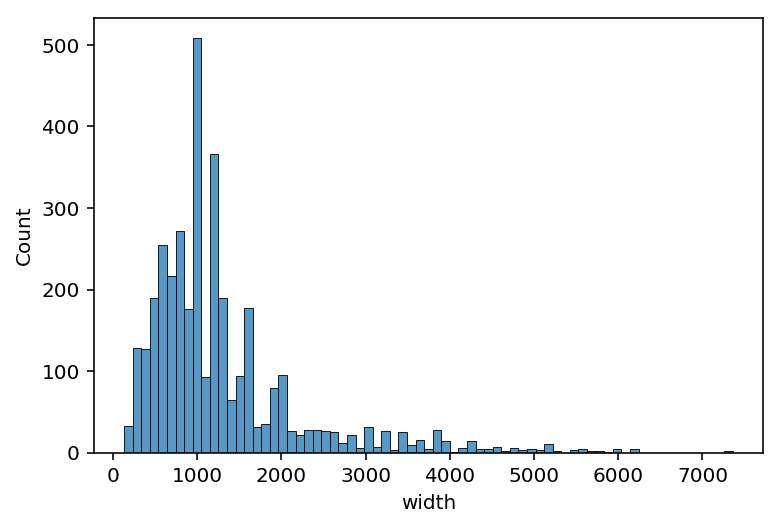

In [11]:
sns.histplot(aspect_ratios['width'])
plt.show()

It looks like the most common aspect ratios are 1:1, 4:3 and 3:2. Furthermore, the most common image width is 1200.

Perhaps then it would be ideal to resize all the images to be 1200 x 1200, using the 1:1 aspect ratio.

In [12]:
# This snippet of code was inspired by https://gist.github.com/zed/4221180
# It was editted slightly to fit our problem

def crop_resize(image, size, ratio):
    
    
    image = Image.open(image)
    
    # crop to ratio, center
    w, h = image.size
    if w > ratio * h: # width is larger then necessary
        x, y = (w - ratio * h) // 2, 0
    else: # ratio*height >= width (height is larger)
        x, y = 0, (h - w / ratio) // 2
    image = image.crop((x, y, w - x, h - y))

    # resize
    image = image.resize(size)
    
    return image

### Testing on apple_1:

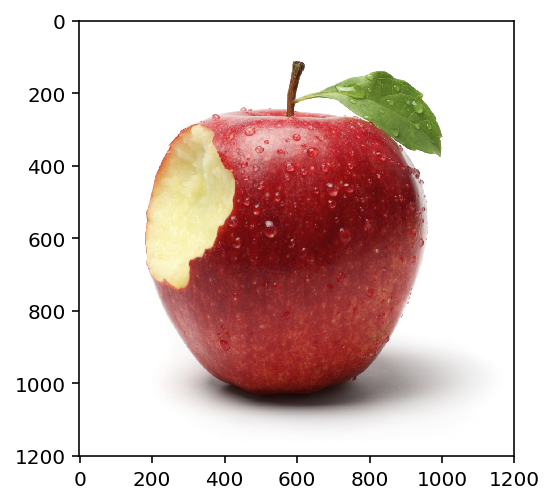

In [13]:
apple_1_resized = np.array(crop_resize(apple_1_fp, (1200, 1200), 1))
plt.imshow(apple_1_resized)

In [14]:
apple_1_resized.shape

(1200, 1200, 3)

Looks like it worked! The proportions of the apple have been preserved, the image is still fairly high-resolution and it has been reshaped correctly. 

Let's test this for a few different images to make sure.

Pomegranate/Image_3 looks to be slightly off-center. Let's see how it looks after resizing:

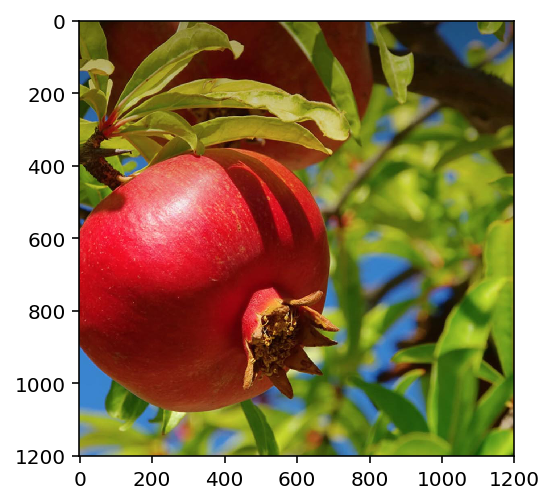

In [15]:
pomegranate_3_resized = np.array(crop_resize('./train/pomegranate/Image_3.jpg', (1200, 1200), 1))
plt.imshow(pomegranate_3_resized)

In [16]:
pomegranate_3_resized.shape

(1200, 1200, 3)

The pomegranate is slightly off-center but this seems like a decent solution.

Jalapeno/Image_53 is very small. Let's see how the resizing algorithm works in that case:

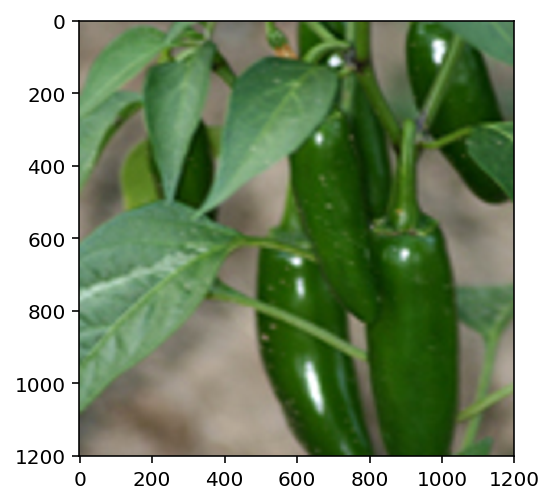

In [17]:
jalapeno_53_resized = np.array(crop_resize('./train/jalepeno/Image_53.jpg', (1200, 1200), 1))
plt.imshow(jalapeno_53_resized)

In [18]:
jalapeno_53_resized.shape

(1200, 1200, 3)

The image is not very clear, as is to be expected, but nothing weird is happening. This looks solid.

### Cropping and resizing all images and exporting them
Here we crop and resize all images to be 1200x1200, then export them to a new folder for posteriority.

We are making a new directory in repo for processed/recropped images. We are going to call this directory 'processed_train'.

We have already run the code below once to process the training images. We do not have to run this each time.

In [19]:
'''
# looping through all subdirectories in train and making
# them in the processed_train folder
for i in os.walk('./train/'):
    
    path = i[0]
    path = path[0:2] + 'processed_' + path[2:]
    
    # making directories
    os.makedirs(path)'''

"\n# looping through all subdirectories in train and making\n# them in the processed_train folder\nfor i in os.walk('./train/'):\n    \n    path = i[0]\n    path = path[0:2] + 'processed_' + path[2:]\n    \n    # making directories\n    os.makedirs(path)"

In [20]:
'''# looping through subdirectories
for i in os.walk('./train/'):
    
    name = i[0]
    img_arr = i[2]
    
    for imgs in img_arr:
        orig_image_fp = name + '/' + imgs
        
        # obtaining the cropped version of the original image
        veg_cropped_arr = np.array(crop_resize(orig_image_fp, (1200, 1200), 1))
        img_cropped_image = Image.fromarray(veg_cropped_arr) # gets image of np array

        # storing cropped image to new path
        new_fp = orig_image_fp[0:2] + 'processed_' + orig_image_fp[2:]

        #  reducing the alpha channel (4th channel) in PNG to RGB only channels for JPG conversion
        img_cropped_image = img_cropped_image.convert('RGB')
        img_cropped_image.save(new_fp)
        '''

"# looping through subdirectories\nfor i in os.walk('./train/'):\n    \n    name = i[0]\n    img_arr = i[2]\n    \n    for imgs in img_arr:\n        orig_image_fp = name + '/' + imgs\n        \n        # obtaining the cropped version of the original image\n        veg_cropped_arr = np.array(crop_resize(orig_image_fp, (1200, 1200), 1))\n        img_cropped_image = Image.fromarray(veg_cropped_arr) # gets image of np array\n\n        # storing cropped image to new path\n        new_fp = orig_image_fp[0:2] + 'processed_' + orig_image_fp[2:]\n\n        #  reducing the alpha channel (4th channel) in PNG to RGB only channels for JPG conversion\n        img_cropped_image = img_cropped_image.convert('RGB')\n        img_cropped_image.save(new_fp)\n        "

Now, we should have all images in our processed_train directory saved in 1200 x 1200 dimension!

# PCA

To perform PCA on an RGB image (as opposed to greyscale images), we will need to obtain the 3 respective RGB channels and perform PCA seperately on them to reduce dimensions in each color channel. We use this [article](https://towardsdatascience.com/dimensionality-reduction-of-a-color-photo-splitting-into-rgb-channels-using-pca-algorithm-in-python-ba01580a1118): as a reference to split the channels.

In [3]:
app10 = cv2.imread('./processed_train/apple/Image_10.jpg')
app_arr = cv2.split(app10) # splits in BGR order not RGB

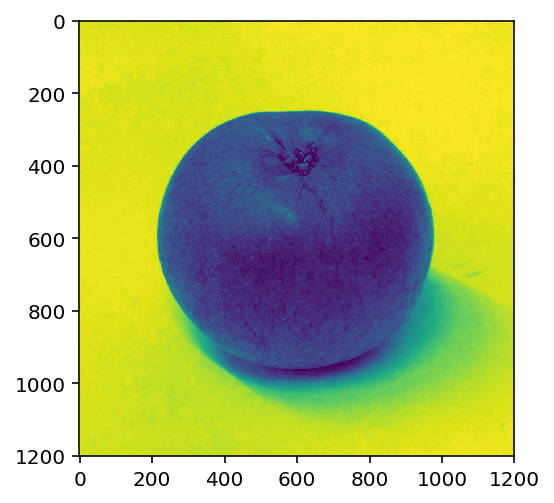

In [4]:
# displaying the blue channel
plt.imshow(app_arr[0])

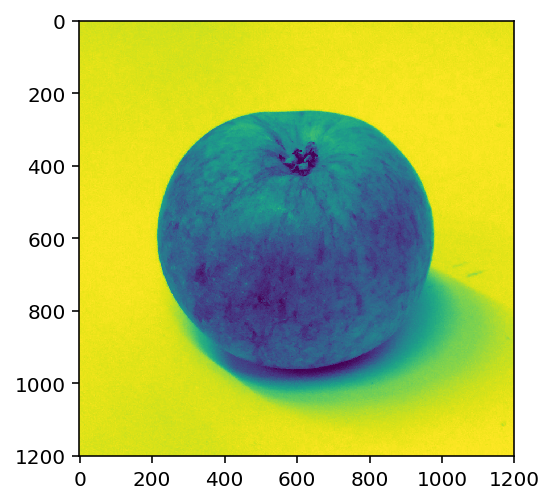

In [5]:
# displaying the green channel
plt.imshow(app_arr[1])

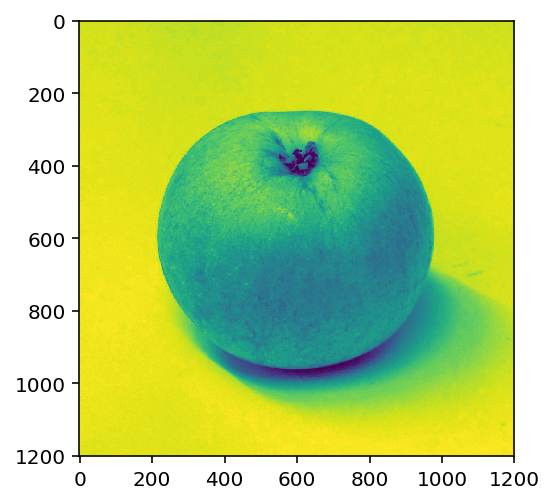

In [6]:
# displaying the red channel
plt.imshow(app_arr[2])

In [9]:
'''
Function takes in color channel of image and PCA dimensions to reduce to, and outputs the reduced channel array
'''
def PCA_transform_channel(channel, dim):
    
    channel_app = PCA(n_components = dim) # num dimensions
    channel_pca = channel_app.fit_transform(channel)
    return channel_app.inverse_transform(channel_pca)

In [10]:
'''
Function takes in image file path and PCA dimensions to reduce to, and outputs the reduced image
'''
def image_PCA_transform(img_fp, dim):
    
    # splitting RGB channels into 3 Np arrays
    cv_img = cv2.imread(img_fp)
    cv_img_arr = cv2.split(cv_img)
    
    new_channels = [] # will contain the reduced arrays
    
    for i in range(len(cv_img_arr)):
        new_channels.append(PCA_transform_channel(cv_img_arr[i], dim))
        
    merged_image = cv2.merge(new_channels)
    return merged_image

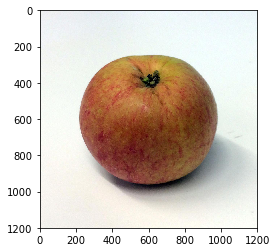

In [11]:
apple_image_fp = './processed_train/apple/Image_10.jpg'
apple_image_orig = mpimg.imread(apple_image_fp)
apple_image_transformed = image_PCA_transform(apple_image_fp, 1200)
plt.imshow(apple_image_orig)

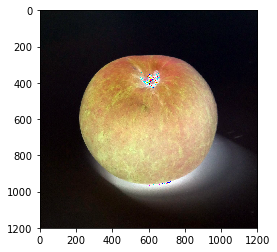

In [12]:
plt.imshow(apple_image_transformed) # BGR not RGB

# PCA on all training images

Let us run PCA on all training images. Let us convert each image to an array and then append that to a master list for each channel.

In [2]:
master_blue = []
master_green = []
master_red = []

In [3]:
# looping through subdirectories
for i in os.walk('./processed_train/'):
    
    name = i[0]
    img_arr = i[2]
    
    for imgs in img_arr:
        orig_image_fp = name + '/' + imgs
        
        try:
        
            fruit = cv2.imread(orig_image_fp)
            fruit_arr = cv2.split(fruit) # splits in BGR order not RGB
        
            master_blue.append(fruit_arr[0] / 255)
            master_green.append(fruit_arr[1] / 255)
            master_red.append(fruit_arr[2] / 255)
            
        except:
            print('Error: ' + orig_image_fp)

Error: ./processed_train//.DS_Store


We need to flatten the array for each image, which is currently of dimension 1,200 x 1,200. into an array of length 1,440,000 as PCA takes in a 2D array as input

In [4]:
for i in range(len(master_blue)):
    master_blue[i] = master_blue[i].flatten()
    master_green[i] = master_green[i].flatten()
    master_red[i] = master_red[i].flatten()

In [ ]:
master_blue_transformed = PCA_transform_channel(master_blue, 30) # taking forever to run

a_file = open('master_blue.txt', 'w')

for row in master_blue_transformed:
    np.savetxt(a_file, row)
    
a_file.close()

In [ ]:
master_green_transformed = PCA_transform_channel(master_green, 30) # taking forever to run

b_file = open('master_green.txt', 'w')

for row in master_green_transformed:
    np.savetxt(b_file, row)

b_file.close()

In [ ]:
master_red_transformed = PCA_transform_channel(master_red, 30) # taking forever to run

c_file = open('master_red.txt', 'w')

for row in master_red_transformed:
    np.savetxt(c_file, row)

c_file.close()

In [ ]:
masters = [master_blue, master_green, master_red]

---

# Spectral Clustering

Loading in images into a dataframe:

In [ ]:
%%time
images = {'img' : [],
         'class' : []}

train_dir = './processed_train'
for fruit_folder in os.listdir(train_dir):
    #Get folder filepath
    folder_dir = os.path.join(train_dir, fruit_folder)
    for img_file in os.listdir(folder_dir):
        #Get image filepath
        img_fp = os.path.join(folder_dir, img_file)
        #Read image to array
        try:
            img = (mpimg.imread(img_fp).flatten()) / 255
        except:
            print('ERROR: ' + img_fp)
        #Add data to dataframe
        images['img'].append(img)
        images['class'].append(fruit_folder)
    print(f'Added all {fruit_folder}s!')
        
images_df = pd.DataFrame(images)

Added all apples!
Added all turnips!
Added all chilli peppers!
Added all raddishs!
Added all bell peppers!
Added all pears!
Added all sweetpotatos!
Added all pomegranates!
Added all peass!
Added all capsicums!
Added all spinachs!
Added all lettuces!
Added all kiwis!
Added all lemons!
Added all onions!
Added all cauliflowers!
Added all potatos!
Added all jalepenos!


In [ ]:
images_df

In [23]:

spec_clustering = SpectralClustering(n_clusters = 36)

spec_clustering.fit(images_df['img'])

ValueError: setting an array element with a sequence.